# Decision: Promote Employee or Not

##### Dataset Source: https://www.kaggle.com/arashnic/hr-ana

#### Notes About Outcome:
* For some reason, the Validation AUC Score never rose above 0.81 as the pricision for the Validation Dataset results were always in the 0.20-0.40 range. I tried tuning the following: 

1) The size of the train/test/validation datasets, 

2) The regularizers (both the type [bias, kernel, & activity] and weights [both L1 and L2 regularizers], 

3) The number of nodes in each layer, 

4) The value of the dropout layer, 

5) Both including and not including a dropout layer, 

6) Using one layer versus two layers,

7) Adjusting the patience (number of epochs) of the early stopping function,

8) The Batch size for training,

9) Evaluating the results both with and without removing outliers.

Other Items to Keep in Mind:

* This dataset was imbalanced. As I calculate and state in the code: 'Of the 44303 total samples, 3931 are positive, which accounts for 8.873% of the total dataset.'

* To Combat the imbalance in the data, I tried both undersampling and SMOTE. Originally I thought undersampling would have worked better as there are plenty of observations, but in practice, SMOTE returned superior results.

** That said, I am aware of tools like Weights and Balances that allow for automating the testing to tune the hyperparameters for the best results. That is definitely something that I will consider in the future to further improve this model.

#### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import tensorflow_addons as tfa

import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns

import os
import tempfile

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE, ADASYN

#### Versions of Many Libraries Used

In [2]:
print("Pandas", pd.__version__)
print("NumPy", np.__version__)
print("Sklearn", sklearn.__version__)
print("Tensorflow", tf.__version__)
print("Keras", keras.__version__)
print("imblearn", imblearn.__version__)

Pandas 1.4.2
NumPy 1.21.5
Sklearn 1.0.2
Tensorflow 2.9.1
Keras 2.9.0
imblearn 0.7.0


#### Colors Used in Visuals

In [3]:
colors= ['blue', 'orange', 'green', 'red']

#### Ingest Dataset

In [4]:
data = pd.read_csv('HR Analytics- Employee Promotion Data/train.csv', engine='c')
data

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,78,0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,56,0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,0,79,0
54806,13614,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,45,0


#### More Information About Dataset

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
 12  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ MB


#### Data Preprocessing

In [6]:
# Remove rows with missing values
data = data.dropna()

# Remove the employee_id feature
data = data.drop(columns={'employee_id'})

# Rename the 'is_promoted' feature to 'target' and removing the ? from 'awards won'
data.rename(columns={'is_promoted' : 'target', 'awards_won?' : 'awards_won'}, inplace=True)

data.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,target
count,48660.000000,48660.000000,48660.000000,48660.00000,48660.00000,48660.000000,48660.000000
mean,1.251993,35.589437,3.337526,6.31157,0.02314,63.603309,0.086971
std,0.604994,7.534571,1.257922,4.20476,0.15035,13.273502,0.281795
min,1.000000,20.000000,1.000000,1.00000,0.00000,39.000000,0.000000
25%,1.000000,30.000000,3.000000,3.00000,0.00000,51.000000,0.000000
50%,1.000000,34.000000,3.000000,5.00000,0.00000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,8.00000,0.00000,76.000000,0.000000
max,10.000000,60.000000,5.000000,37.00000,1.00000,99.000000,1.000000


#### Remove Outliers (Using IQR * 1.5 Rule)

In [7]:
# Remove outliers using the 'IQR * 1.5' rule
def remove_outliers(df, feature):
    q1, q3 = np.percentile(df[feature], [25,75])
    iqr = q3-q1
    ul = q3 + (iqr * 1.5)
    ll = q1 - (iqr * 1.5)
    neo_data = df[(df[feature].values > ll) & (df[feature].values < ul)]
    return neo_data

data = remove_outliers(data, 'length_of_service')
data = remove_outliers(data, 'age')

#### Unique Values in Each Feature

In [8]:
for col in data:
    print(data[col].name, '\t\t', data[col].dtype, '\n', sorted(data[col].unique()), '\n')

department 		 object 
 ['Analytics', 'Finance', 'HR', 'Legal', 'Operations', 'Procurement', 'R&D', 'Sales & Marketing', 'Technology'] 

region 		 object 
 ['region_1', 'region_10', 'region_11', 'region_12', 'region_13', 'region_14', 'region_15', 'region_16', 'region_17', 'region_18', 'region_19', 'region_2', 'region_20', 'region_21', 'region_22', 'region_23', 'region_24', 'region_25', 'region_26', 'region_27', 'region_28', 'region_29', 'region_3', 'region_30', 'region_31', 'region_32', 'region_33', 'region_34', 'region_4', 'region_5', 'region_6', 'region_7', 'region_8', 'region_9'] 

education 		 object 
 ["Bachelor's", 'Below Secondary', "Master's & above"] 

gender 		 object 
 ['f', 'm'] 

recruitment_channel 		 object 
 ['other', 'referred', 'sourcing'] 

no_of_trainings 		 int64 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 

age 		 int64 
 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49] 

previous_year_rating 		 float64 

#### Additional Information About Dataset After Edits

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44303 entries, 0 to 54807
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            44303 non-null  object 
 1   region                44303 non-null  object 
 2   education             44303 non-null  object 
 3   gender                44303 non-null  object 
 4   recruitment_channel   44303 non-null  object 
 5   no_of_trainings       44303 non-null  int64  
 6   age                   44303 non-null  int64  
 7   previous_year_rating  44303 non-null  float64
 8   length_of_service     44303 non-null  int64  
 9   awards_won            44303 non-null  int64  
 10  avg_training_score    44303 non-null  int64  
 11  target                44303 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 4.4+ MB


#### Additional Information About Dataset After Edits

In [10]:
data.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,target
count,44303.000000,44303.000000,44303.000000,44303.000000,44303.000000,44303.000000,44303.000000
mean,1.260276,33.961018,3.339368,5.565560,0.023678,63.726317,0.088730
std,0.610277,5.542368,1.260114,2.964149,0.152045,13.361678,0.284357
min,1.000000,20.000000,1.000000,1.000000,0.000000,39.000000,0.000000
25%,1.000000,30.000000,3.000000,3.000000,0.000000,52.000000,0.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000,0.000000
75%,1.000000,38.000000,4.000000,7.000000,0.000000,76.000000,0.000000
max,10.000000,49.000000,5.000000,15.000000,1.000000,99.000000,1.000000


#### Convert Object Features to Numeric Values

In [11]:
data.rename(columns={'gender' : 'is_male'}, inplace=True)

data['is_male'].replace({'m' : 1, 'f': 0}, inplace=True)

cat_features = ['department', 'region', 
               'education', 'recruitment_channel']

# use panda's get_dummies and then merge them to the base table
for x in cat_features:
    sparse_data = pd.DataFrame(pd.get_dummies(data[x]))
    data = data.join(sparse_data)

# Remove the unnecessary features
data.drop(columns=cat_features, inplace=True)

data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44303 entries, 0 to 44302
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is_male               44303 non-null  int64  
 1   no_of_trainings       44303 non-null  int64  
 2   age                   44303 non-null  int64  
 3   previous_year_rating  44303 non-null  float64
 4   length_of_service     44303 non-null  int64  
 5   awards_won            44303 non-null  int64  
 6   avg_training_score    44303 non-null  int64  
 7   target                44303 non-null  int64  
 8   Analytics             44303 non-null  uint8  
 9   Finance               44303 non-null  uint8  
 10  HR                    44303 non-null  uint8  
 11  Legal                 44303 non-null  uint8  
 12  Operations            44303 non-null  uint8  
 13  Procurement           44303 non-null  uint8  
 14  R&D                   44303 non-null  uint8  
 15  Sales & Marketing  

Normally, I would inspect the dataset for duplicates and determine whether to remove duplicates or not, but this dataset does not look to have any. Next, I am checking to see if there is an imbalance in the target values. As you can see, there is (1 means the employee was promoted)!

#### Calculating Distribution of Imbalanced Data

In [12]:
neg, pos = np.bincount(data['target'])
total = neg + pos

print("Of the {} total samples, {} are positive, which accounts for {}% of the total dataset".
      format(total, pos, round(pos/total*100,3)))

Of the 44303 total samples, 3931 are positive, which accounts for 8.873% of the total dataset


#### Split Dataset into Train/Test/Validation Datasets

In [13]:
#split and shuffle your dataset.
train_data, test_val_data = train_test_split(data, test_size=0.40, shuffle=True, random_state=42)
val_data, test_data = train_test_split(test_val_data, test_size=0.50, shuffle=True, random_state=42)

# Form np arrays of labels and features.
train_labels = np.array(train_data.pop('target'))

train_features = np.array(train_data)

smote = SMOTE(sampling_strategy='all', random_state=63)
train_features, train_labels = smote.fit_resample(train_features, train_labels)

bool_train_labels = train_labels != 0
val_labels = np.array(val_data.pop('target'))
test_labels = np.array(test_data.pop('target'))

val_features = np.array(val_data)
test_features = np.array(test_data)

#### Apply Sklearn StandardScaler

In [14]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# Use np.clip afterwards
train_features = np.clip(train_features, -4, 4)
val_features = np.clip(val_features, -4, 4)
test_features = np.clip(test_features, -4, 4)

print('Train labels shape:', train_labels.shape)
print('Val labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Train features shape:', train_features.shape)
print('Val features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Train labels shape: (48576,)
Val labels shape: (8861,)
Test labels shape: (8861,)
Train features shape: (48576, 56)
Val features shape: (8861, 56)
Test features shape: (8861, 56)


#### Visualize Data So Far

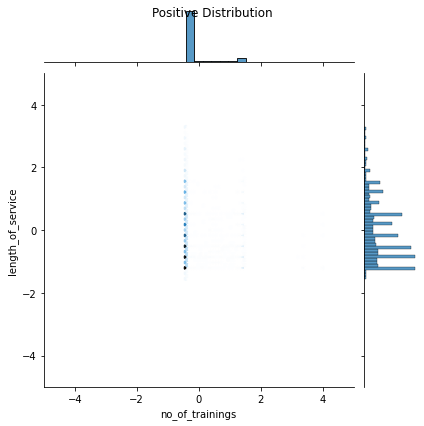

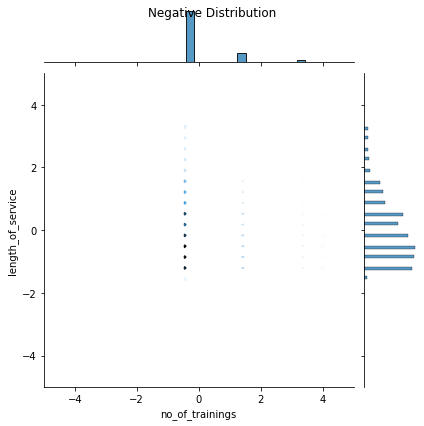

In [15]:
pos_data = pd.DataFrame(train_features[bool_train_labels], 
                        columns=train_data.columns)
neg_data = pd.DataFrame(train_features[~bool_train_labels], 
                        columns=train_data.columns)

sns.jointplot(x=pos_data['no_of_trainings'], 
              y=pos_data['length_of_service'], 
              kind='hex', xlim=(-5,5), ylim=(-5,5))

plt.suptitle("Positive Distribution")

sns.jointplot(x=neg_data['no_of_trainings'], 
              y=neg_data['length_of_service'],
             kind='hex', xlim=(-5,5), ylim=(-5, 5))

_ = plt.suptitle('Negative Distribution')

#### Define Metrics for Model

In [16]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

2022-09-27 21:26:19.718118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Build & Compile Model

In [17]:
def make_model(metrics=METRICS):
    l1_val = 0.003
    l2_val = 0.08
    model = keras.Sequential([
        keras.layers.Dense(12, 
                           activation='relu', 
                           kernel_regularizer=regularizers.L1L2(l1=l1_val, l2=l2_val),
                           bias_regularizer=regularizers.L1(l1_val), 
                           activity_regularizer=regularizers.L1(l1_val), 
                           input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.20),
        keras.layers.Dense(12, 
                           activation='relu', 
                           kernel_regularizer=regularizers.L1L2(l1=l1_val, l2=l2_val),
                           bias_regularizer=regularizers.L1(l1_val), 
                           activity_regularizer=regularizers.L1(l1_val)),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)
    
    return model

#### Early Stopping Callback for Baseline Model

In [18]:
EPOCHS = 250
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, 
                                                  patience=8,
                                                  monitor='val_auc', 
                                                  mode='max') 

#### Summary of Inputs

In [19]:
model = make_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                684       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 853
Trainable params: 853
Non-trainable params: 0
_________________________________________________________________


#### Train Baseline Model

In [20]:
model = make_model()
history = model.fit(
    train_features, 
    train_labels, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/250
24/24 [==============================] - 3s 46ms/step - loss: 3.3291 - tp: 15741.0000 - fp: 16167.0000 - tn: 8121.0000 - fn: 8547.0000 - accuracy: 0.4912 - precision: 0.4933 - recall: 0.6481 - auc: 0.4814 - val_loss: 3.0567 - val_tp: 461.0000 - val_fp: 4637.0000 - val_tn: 3406.0000 - val_fn: 357.0000 - val_accuracy: 0.4364 - val_precision: 0.0904 - val_recall: 0.5636 - val_auc: 0.4970
Epoch 2/250
24/24 [==============================] - 0s 7ms/step - loss: 2.8280 - tp: 12145.0000 - fp: 12262.0000 - tn: 12026.0000 - fn: 12143.0000 - accuracy: 0.4976 - precision: 0.4976 - recall: 0.5000 - auc: 0.5011 - val_loss: 2.5858 - val_tp: 367.0000 - val_fp: 3576.0000 - val_tn: 4467.0000 - val_fn: 451.0000 - val_accuracy: 0.5455 - val_precision: 0.0931 - val_recall: 0.4487 - val_auc: 0.5150
Epoch 3/250
24/24 [==============================] - 0s 7ms/step - loss: 2.4175 - tp: 10611.0000 - fp: 10334.0000 - tn: 13954.0000 - fn: 13677.0000 - accuracy: 0.5057 - precision: 0.5066 - recall: 0.

24/24 [==============================] - 0s 5ms/step - loss: 0.7111 - tp: 14651.0000 - fp: 7478.0000 - tn: 16810.0000 - fn: 9637.0000 - accuracy: 0.6477 - precision: 0.6621 - recall: 0.6032 - auc: 0.7284 - val_loss: 0.7068 - val_tp: 554.0000 - val_fp: 2472.0000 - val_tn: 5571.0000 - val_fn: 264.0000 - val_accuracy: 0.6912 - val_precision: 0.1831 - val_recall: 0.6773 - val_auc: 0.7575
Epoch 22/250
24/24 [==============================] - 0s 5ms/step - loss: 0.7041 - tp: 14811.0000 - fp: 7455.0000 - tn: 16833.0000 - fn: 9477.0000 - accuracy: 0.6514 - precision: 0.6652 - recall: 0.6098 - auc: 0.7317 - val_loss: 0.6963 - val_tp: 540.0000 - val_fp: 2285.0000 - val_tn: 5758.0000 - val_fn: 278.0000 - val_accuracy: 0.7108 - val_precision: 0.1912 - val_recall: 0.6601 - val_auc: 0.7592
Epoch 23/250
24/24 [==============================] - 0s 5ms/step - loss: 0.6994 - tp: 14547.0000 - fp: 7158.0000 - tn: 17130.0000 - fn: 9741.0000 - accuracy: 0.6521 - precision: 0.6702 - recall: 0.5989 - auc: 0.7

24/24 [==============================] - 0s 5ms/step - loss: 0.6573 - tp: 16529.0000 - fp: 7311.0000 - tn: 16977.0000 - fn: 7759.0000 - accuracy: 0.6898 - precision: 0.6933 - recall: 0.6805 - auc: 0.7665 - val_loss: 0.6375 - val_tp: 534.0000 - val_fp: 2023.0000 - val_tn: 6020.0000 - val_fn: 284.0000 - val_accuracy: 0.7396 - val_precision: 0.2088 - val_recall: 0.6528 - val_auc: 0.7757
Epoch 42/250
24/24 [==============================] - 0s 4ms/step - loss: 0.6552 - tp: 16515.0000 - fp: 7163.0000 - tn: 17125.0000 - fn: 7773.0000 - accuracy: 0.6925 - precision: 0.6975 - recall: 0.6800 - auc: 0.7703 - val_loss: 0.6342 - val_tp: 536.0000 - val_fp: 1997.0000 - val_tn: 6046.0000 - val_fn: 282.0000 - val_accuracy: 0.7428 - val_precision: 0.2116 - val_recall: 0.6553 - val_auc: 0.7765
Epoch 43/250
24/24 [==============================] - 0s 4ms/step - loss: 0.6548 - tp: 16435.0000 - fp: 7055.0000 - tn: 17233.0000 - fn: 7853.0000 - accuracy: 0.6931 - precision: 0.6997 - recall: 0.6767 - auc: 0.7

24/24 [==============================] - 0s 5ms/step - loss: 0.6386 - tp: 17347.0000 - fp: 7050.0000 - tn: 17238.0000 - fn: 6941.0000 - accuracy: 0.7120 - precision: 0.7110 - recall: 0.7142 - auc: 0.7877 - val_loss: 0.6244 - val_tp: 550.0000 - val_fp: 2073.0000 - val_tn: 5970.0000 - val_fn: 268.0000 - val_accuracy: 0.7358 - val_precision: 0.2097 - val_recall: 0.6724 - val_auc: 0.7820
Epoch 62/250
24/24 [==============================] - 0s 5ms/step - loss: 0.6387 - tp: 17238.0000 - fp: 6922.0000 - tn: 17366.0000 - fn: 7050.0000 - accuracy: 0.7124 - precision: 0.7135 - recall: 0.7097 - auc: 0.7874 - val_loss: 0.6182 - val_tp: 538.0000 - val_fp: 1981.0000 - val_tn: 6062.0000 - val_fn: 280.0000 - val_accuracy: 0.7448 - val_precision: 0.2136 - val_recall: 0.6577 - val_auc: 0.7819
Epoch 63/250
24/24 [==============================] - 0s 4ms/step - loss: 0.6398 - tp: 17171.0000 - fp: 7044.0000 - tn: 17244.0000 - fn: 7117.0000 - accuracy: 0.7085 - precision: 0.7091 - recall: 0.7070 - auc: 0.7

24/24 [==============================] - 0s 4ms/step - loss: 0.6268 - tp: 17446.0000 - fp: 6761.0000 - tn: 17527.0000 - fn: 6842.0000 - accuracy: 0.7200 - precision: 0.7207 - recall: 0.7183 - auc: 0.7980 - val_loss: 0.6139 - val_tp: 547.0000 - val_fp: 2011.0000 - val_tn: 6032.0000 - val_fn: 271.0000 - val_accuracy: 0.7425 - val_precision: 0.2138 - val_recall: 0.6687 - val_auc: 0.7867
Epoch 82/250
24/24 [==============================] - 0s 4ms/step - loss: 0.6246 - tp: 17497.0000 - fp: 6650.0000 - tn: 17638.0000 - fn: 6791.0000 - accuracy: 0.7233 - precision: 0.7246 - recall: 0.7204 - auc: 0.8004 - val_loss: 0.6059 - val_tp: 540.0000 - val_fp: 1923.0000 - val_tn: 6120.0000 - val_fn: 278.0000 - val_accuracy: 0.7516 - val_precision: 0.2192 - val_recall: 0.6601 - val_auc: 0.7875
Epoch 83/250
24/24 [==============================] - 0s 4ms/step - loss: 0.6256 - tp: 17556.0000 - fp: 6776.0000 - tn: 17512.0000 - fn: 6732.0000 - accuracy: 0.7219 - precision: 0.7215 - recall: 0.7228 - auc: 0.7

24/24 [==============================] - 0s 4ms/step - loss: 0.6169 - tp: 17554.0000 - fp: 6567.0000 - tn: 17721.0000 - fn: 6734.0000 - accuracy: 0.7262 - precision: 0.7277 - recall: 0.7227 - auc: 0.8061 - val_loss: 0.6013 - val_tp: 540.0000 - val_fp: 1913.0000 - val_tn: 6130.0000 - val_fn: 278.0000 - val_accuracy: 0.7527 - val_precision: 0.2201 - val_recall: 0.6601 - val_auc: 0.7894
Epoch 102/250
24/24 [==============================] - 0s 4ms/step - loss: 0.6169 - tp: 17552.0000 - fp: 6560.0000 - tn: 17728.0000 - fn: 6736.0000 - accuracy: 0.7263 - precision: 0.7279 - recall: 0.7227 - auc: 0.8060 - val_loss: 0.5974 - val_tp: 539.0000 - val_fp: 1882.0000 - val_tn: 6161.0000 - val_fn: 279.0000 - val_accuracy: 0.7561 - val_precision: 0.2226 - val_recall: 0.6589 - val_auc: 0.7916
Epoch 103/250
24/24 [==============================] - 0s 4ms/step - loss: 0.6138 - tp: 17738.0000 - fp: 6561.0000 - tn: 17727.0000 - fn: 6550.0000 - accuracy: 0.7301 - precision: 0.7300 - recall: 0.7303 - auc: 0

24/24 [==============================] - 0s 5ms/step - loss: 0.6061 - tp: 17754.0000 - fp: 6337.0000 - tn: 17951.0000 - fn: 6534.0000 - accuracy: 0.7350 - precision: 0.7370 - recall: 0.7310 - auc: 0.8172 - val_loss: 0.5867 - val_tp: 537.0000 - val_fp: 1786.0000 - val_tn: 6257.0000 - val_fn: 281.0000 - val_accuracy: 0.7667 - val_precision: 0.2312 - val_recall: 0.6565 - val_auc: 0.7928
Epoch 122/250
24/24 [==============================] - 0s 5ms/step - loss: 0.6075 - tp: 17774.0000 - fp: 6423.0000 - tn: 17865.0000 - fn: 6514.0000 - accuracy: 0.7337 - precision: 0.7346 - recall: 0.7318 - auc: 0.8149 - val_loss: 0.5827 - val_tp: 522.0000 - val_fp: 1731.0000 - val_tn: 6312.0000 - val_fn: 296.0000 - val_accuracy: 0.7712 - val_precision: 0.2317 - val_recall: 0.6381 - val_auc: 0.7924
Epoch 123/250
24/24 [==============================] - 0s 5ms/step - loss: 0.6064 - tp: 17663.0000 - fp: 6355.0000 - tn: 17933.0000 - fn: 6625.0000 - accuracy: 0.7328 - precision: 0.7354 - recall: 0.7272 - auc: 0

24/24 [==============================] - 0s 5ms/step - loss: 0.5994 - tp: 17784.0000 - fp: 6051.0000 - tn: 18237.0000 - fn: 6504.0000 - accuracy: 0.7415 - precision: 0.7461 - recall: 0.7322 - auc: 0.8232 - val_loss: 0.5792 - val_tp: 526.0000 - val_fp: 1725.0000 - val_tn: 6318.0000 - val_fn: 292.0000 - val_accuracy: 0.7724 - val_precision: 0.2337 - val_recall: 0.6430 - val_auc: 0.7939
Epoch 142/250
24/24 [==============================] - 0s 4ms/step - loss: 0.5987 - tp: 17964.0000 - fp: 6232.0000 - tn: 18056.0000 - fn: 6324.0000 - accuracy: 0.7415 - precision: 0.7424 - recall: 0.7396 - auc: 0.8240 - val_loss: 0.5699 - val_tp: 521.0000 - val_fp: 1625.0000 - val_tn: 6418.0000 - val_fn: 297.0000 - val_accuracy: 0.7831 - val_precision: 0.2428 - val_recall: 0.6369 - val_auc: 0.7949
Epoch 143/250
24/24 [==============================] - 0s 5ms/step - loss: 0.5981 - tp: 17842.0000 - fp: 6039.0000 - tn: 18249.0000 - fn: 6446.0000 - accuracy: 0.7430 - precision: 0.7471 - recall: 0.7346 - auc: 0

#### Create Function to Plot metrics

In [21]:
def plot_metrics(history):
    metrics = ['loss', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace('_', '').capitalize()
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[2], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric =='auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
            
        plt.legend()
        plt.show()

#### Plotting Metrics for Baseline Metrics

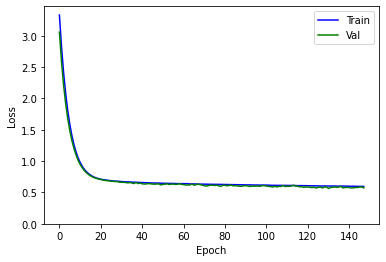

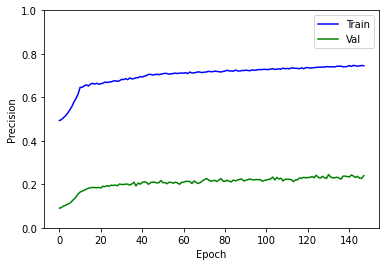

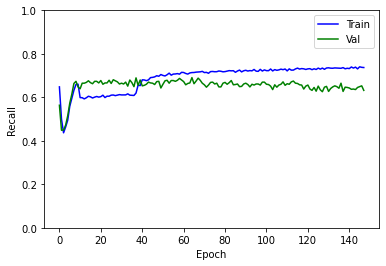

In [22]:
plot_metrics(history)

#### Inference

In [23]:
train_preds = model.predict(train_features, batch_size=BATCH_SIZE)
test_preds = model.predict(test_features, batch_size=BATCH_SIZE)

5/5 [==============================] - 0s 2ms/step


#### Create Function to Plot Confusion Matrix

In [24]:
def plot_cm(labels, predictions, p=0.50):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix @{:.2f}'.format(p))
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')

#### Evaluate Metrics

loss : 0.5765640735626221
tp : 519.0
fp : 1665.0
tn : 6376.0
fn : 301.0
accuracy : 0.7781288623809814
precision : 0.23763735592365265
recall : 0.6329268217086792
auc : 0.790950357913971



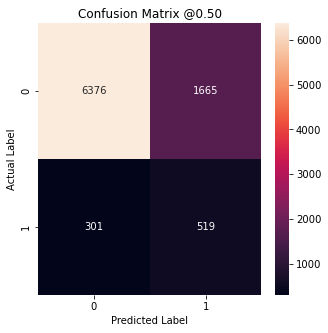

In [25]:
results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE,
                                  verbose=0)

for name, value in zip(model.metrics_names, results):
    print(name, ':', value)
print()

plot_cm(test_labels, test_preds)

#### Define Function to Plot ROC

In [26]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.title('ROC Curve')
    plt.xlabel('False Positives [%]')
    plt.ylabel('True Positives [%]')
    plt.grid(True)
    plt.xlim([-2,102])
    plt.ylim([-2,102])
    ax = plt.gca()
    ax.plot([0,1],[0,1], transform=ax.transAxes, color=colors[3])
    ax.set_aspect('equal')

#### Plot ROC for Baseline Model

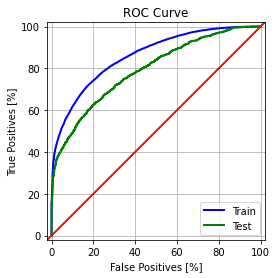

In [27]:
plot_roc("Train", train_labels, 
         train_preds, 
         color=colors[0])

plot_roc("Test", test_labels, 
         test_preds, 
         color=colors[2])

plt.legend(loc='lower right')
plt.show()

#### Save the Model

In [28]:
model.save('Decision:PromoteOrNot')

INFO:tensorflow:Assets written to: Decision:PromoteOrNot/assets
